In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error,mean_absolute_error, f1_score
import lightgbm as lgb
import xgboost
import os
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold
import logging

In [2]:
plt.rcParams['font.family']='STSong'
plt.rcParams['font.size']=10
pd.set_option('display.max_columns', None)

In [3]:
train = pd.read_csv("dataset/happiness_train_complete.csv", parse_dates=["survey_time"], encoding='latin-1')
test = pd.read_csv("dataset/happiness_test_complete.csv", parse_dates=["survey_time"], encoding='latin-1')

In [4]:
train_data = train[train["happiness"]!=-8].reset_index(drop=True)
print('train shape:',train_data.shape)
train_data_copy = train_data.copy()
target_col = "happiness"
target = train_data_copy[target_col]#.apply(lambda x:np.log1p(x))
del train_data_copy[target_col]

train shape: (7988, 140)


In [5]:
train_shape = train_data.shape[0]
data = pd.concat([train_data_copy,test],axis=0,ignore_index=True)

In [6]:
train=data
train=train.drop(["edu_other"], axis=1)

In [7]:
train["hukou_loc"]=train["hukou_loc"].fillna(1)
train["social_neighbor"]=train["social_neighbor"].fillna(8)
train["social_friend"]=train["social_friend"].fillna(8)
train["edu_status"]=train["edu_status"].fillna(5)
train["edu_yr"]=train["edu_yr"].fillna(-2)
train["work_status"]=train["work_status"].fillna(0)
train["work_yr"]=train["work_yr"].fillna(0)

In [8]:
train["minor_child"]=train["minor_child"].fillna(0)
train["marital_1st"]=train["marital_1st"].fillna(0)
train["s_birth"]=train["s_birth"].fillna(0)
train["marital_now"]=train["marital_now"].fillna(0)
train["s_edu"]=train["s_edu"].fillna(0)
train["work_type"]=train["work_type"].fillna(0)
train["work_manage"]=train["work_manage"].fillna(0)
train["family_income"]=train["family_income"].fillna(-2)

In [9]:
train["s_political"]=train["s_political"].fillna(0)
train["s_hukou"]=train["s_hukou"].fillna(0)
train["s_income"]=train["s_income"].fillna(0)
train["s_work_exper"]=train["s_work_exper"].fillna(0)
train["s_work_status"]=train["s_work_status"].fillna(0)
train["s_work_type"]=train["s_work_type"].fillna(0)

In [10]:
data=train

In [11]:
data.loc[data['health_problem']<0,'health_problem'] = 0
data.loc[data['religion']<0,'religion'] = 1
data.loc[data['religion_freq']<0,'religion_freq'] = 1
data.loc[data['edu']<0,'edu'] = 0
data.loc[data['edu_status']<0,'edu_status'] = 0
data.loc[data['income']<0,'income'] = 0
data.loc[data['s_income']<0,'s_income']= 0

In [12]:
data.loc[data['family_income']<=0,'family_income']=0
data.loc[data['inc_exp']<=0,'inc_exp']= 0

In [13]:
data.loc[data['equity']<0,'equity'] = 0
data.loc[data['social_neighbor']<0,'social_neighbor'] = 0

In [14]:
data.loc[data['class_10_after']<0,'class_10_after'] = 0
data.loc[data['class_10_before']<0,'class_10_before'] = 0
data.loc[data['class']<0,'class'] = 0
data.loc[data['class_14']<0,'class_14'] = 0
data.loc[data['family_m']<0,'family_m'] = 1

In [15]:
data.loc[data['health']<0,'health'] = 0

In [16]:
data.loc[data['edu_yr']<0,'edu_yr'] = 0
data['survey_time'] = pd.to_datetime(data['survey_time'])
data.loc[data['marital_1st']<0,'marital_1st']= -1
data.loc[data['marital_now']<0,'marital_now']= -1

In [17]:
data.loc[data['join_party']<0,'join_party']= -1

In [18]:
#配偶年龄
data['marital_sage'] = data['marital_now']-data['s_birth']
#毕业年龄
data['eduage'] = data['edu_yr'] - data['birth']
#被调查者年龄
data['survey_age'] = 2015-data['birth']
#最近结婚年龄
data['marital_age'] = data['marital_now'] - data['birth']

In [19]:
#收入比
data['income/s_income'] = data['income']/(data['s_income']+1)
data['income/family_income'] = data['income']/(data['family_income']+1)

In [20]:
#等级
data['class_10_a'] = (data['class_10_after'] - data['class_10_before'])
data['class_a'] = data['class'] - data['class_10_before']
data['class_14_a'] = data['class'] - data['class_14']
# print(data)

In [21]:
data=data.drop(["work_exper"], axis=1)
data=data.drop(["social_neighbor"], axis=1)
data=data.drop(["inc_ability"], axis=1)

In [35]:
use_fea = [clo for clo in data.columns if clo!='survey_time' and data[clo].dtype!=object]
features = data[use_fea].columns
X_train = data[:train_shape][use_fea].values
y_train = target
X_test = data[train_shape:][use_fea].values

In [81]:
X_train.shape

(7988, 141)

In [80]:
X_test.shape

(2968, 141)

In [23]:
param = {
'num_leaves': 80,
'min_data_in_leaf': 40,
'objective':'regression',
'max_depth': -1,
'learning_rate': 0.01,
"min_child_samples": 30,
"boosting": "gbdt",
"feature_fraction": 0.8,
"bagging_freq": 2,
"bagging_fraction": 0.8,
"bagging_seed": 2020,
"metric": 'mse',
"lambda_l1": 0.1,
"lambda_l2": 0.2,
"verbosity": -1}
folds = KFold(n_splits=10, shuffle=True, random_state=1100)
oof_lgb = np.zeros(len(X_train))
predictions_lgb = np.zeros(len(X_test))

In [121]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

fold n°1
Training until validation scores don't improve for 200 rounds
[200]	training's l2: 0.341002	valid_1's l2: 0.501474
[400]	training's l2: 0.236173	valid_1's l2: 0.48367
[600]	training's l2: 0.171494	valid_1's l2: 0.482786
Early stopping, best iteration is:
[558]	training's l2: 0.183077	valid_1's l2: 0.482197
fold n°2
Training until validation scores don't improve for 200 rounds
[200]	training's l2: 0.344493	valid_1's l2: 0.466534
[400]	training's l2: 0.238736	valid_1's l2: 0.448124
[600]	training's l2: 0.173068	valid_1's l2: 0.442564
[800]	training's l2: 0.128318	valid_1's l2: 0.44153
Early stopping, best iteration is:
[746]	training's l2: 0.138792	valid_1's l2: 0.441306
fold n°3
Training until validation scores don't improve for 200 rounds
[200]	training's l2: 0.343706	valid_1's l2: 0.469964
[400]	training's l2: 0.238428	valid_1's l2: 0.450882
[600]	training's l2: 0.173426	valid_1's l2: 0.446397
Early stopping, best iteration is:
[591]	training's l2: 0.175813	valid_1's l2: 0.44

In [122]:
e=mean_squared_error(target.values, oof_lgb)
print(e)

0.45684635409636487


In [124]:
submit = pd.read_csv("dataset/happiness_submit.csv")
submision_lgb1  = pd.DataFrame({"id":submit['id'].values})
submision_lgb1["happiness"]=predictions_lgb
submision_lgb1.to_csv("./baseline.csv" , index=False)
submision_lgb1.head(5)

,id,happiness
0,8001,3.842003
1,8002,2.812625
2,8003,3.310622
3,8004,4.339162
4,8005,3.284053


In [42]:
where_are_nan = np.isnan(X_train)
where_are_inf = np.isinf(X_train)

In [41]:
X_train[where_are_nan] = -1
X_train[where_are_inf] = -1

In [50]:
X_train = X_train.astype(float)

In [24]:
from sklearn.linear_model import LinearRegression

In [117]:
def lin_train():
    lin_reg = LinearRegression()
    lin_reg.fit(X_train[:7000],y_train[:7000])

    lin_mse = mean_squared_error(y_train[7000:],lin_reg.predict(X_train[7000:]))
#     lin_rmse = np.sqrt(lin_mse)
    print(lin_mse)
    return lin_reg

In [118]:
lin_model = lin_train()

0.5080781401892178


In [54]:
from sklearn.tree import DecisionTreeRegressor

In [119]:
def tree_train():
    tree_reg = DecisionTreeRegressor()
    tree_reg.fit(X_train[:7000],y_train[:7000])

    tree_mse = mean_squared_error(y_train[7000:], tree_reg.predict(X_train[7000:]))
#     tree_rmse = np.sqrt(tree_mse)
    print(tree_mse)
    return tree_reg

In [120]:
dt_model = tree_train()

1.008097165991903


In [65]:
from sklearn.ensemble import RandomForestRegressor

In [121]:
def forest_train():
    #随机森林


    forest_reg = RandomForestRegressor()
    forest_reg.fit(X_train[:7000],y_train[:7000])

    forest_mse = mean_squared_error(y_train[7000:], forest_reg.predict(X_train[7000:]))
#     forest_rmse = np.sqrt(forest_mse)
    print(forest_mse)
    return forest_reg

In [122]:
rf_model = forest_train()

0.5150546558704454


In [85]:
where_are_nan = np.isnan(X_test)
where_are_inf = np.isinf(X_test)

In [86]:
X_test[where_are_nan] = -1
X_test[where_are_inf] = -1
X_test = X_test.astype(float)

In [88]:
submit = pd.read_csv("dataset/happiness_submit.csv")
submision  = pd.DataFrame({"id":submit['id'].values})

In [108]:
submision["happiness"]=lin_model.predict(X_test)
submision.to_csv("./lin_model.csv" , index=False)
submision.head(5)

,id,happiness
0,8001,3.922987
1,8002,3.137701
2,8003,3.612186
3,8004,4.326218
4,8005,2.850476


In [103]:
submision["happiness"]=dt_model.predict(X_test)
submision.to_csv("./dt_model.csv" , index=False)
submision.head(5)

,id,happiness
0,8001,3.0
1,8002,4.0
2,8003,2.0
3,8004,3.0
4,8005,2.0


In [109]:
submision["happiness"]=rf_model.predict(X_test)
submision.to_csv("./rf_model.csv" , index=False)
submision.head(5)

,id,happiness
0,8001,3.80
1,8002,2.64
2,8003,3.23
3,8004,4.37
4,8005,3.24


Text(0.5, 0, 'nums_of_null')

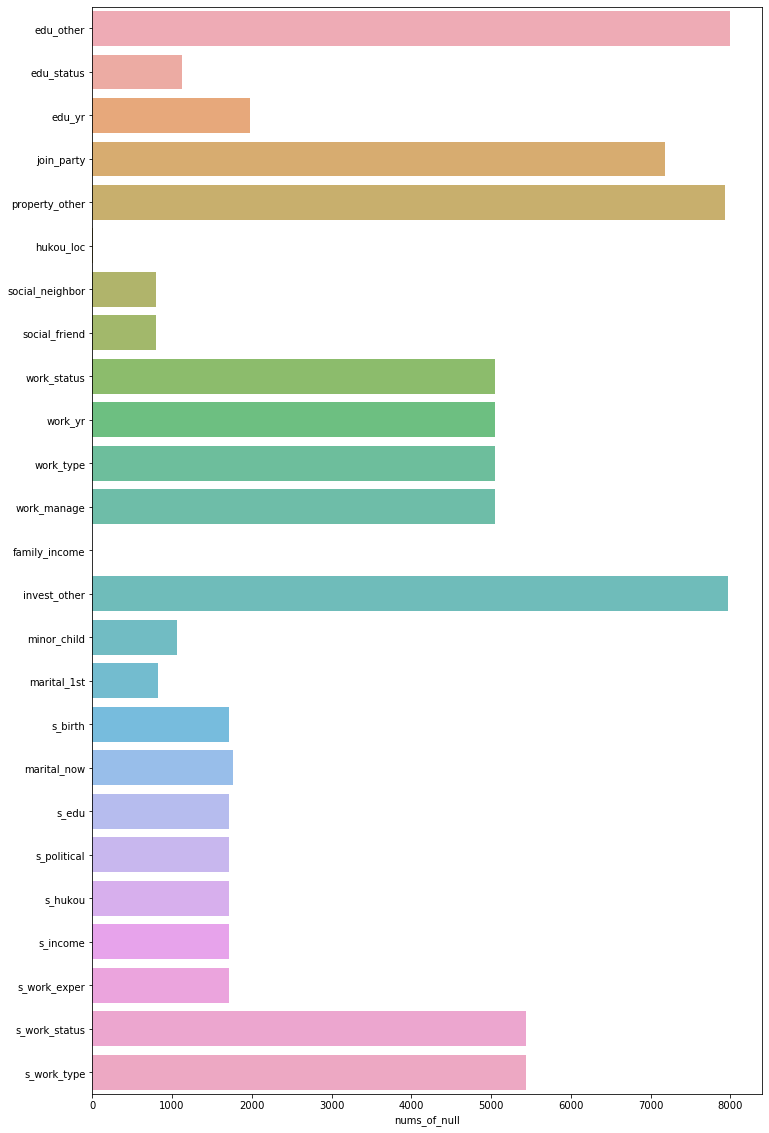

In [64]:
f, ax=plt.subplots(figsize=(12,20))
sns.barplot(y=null_dims.index, x=null_dims.values, orient='h', alpha=0.8)
plt.xlabel("nums_of_null")

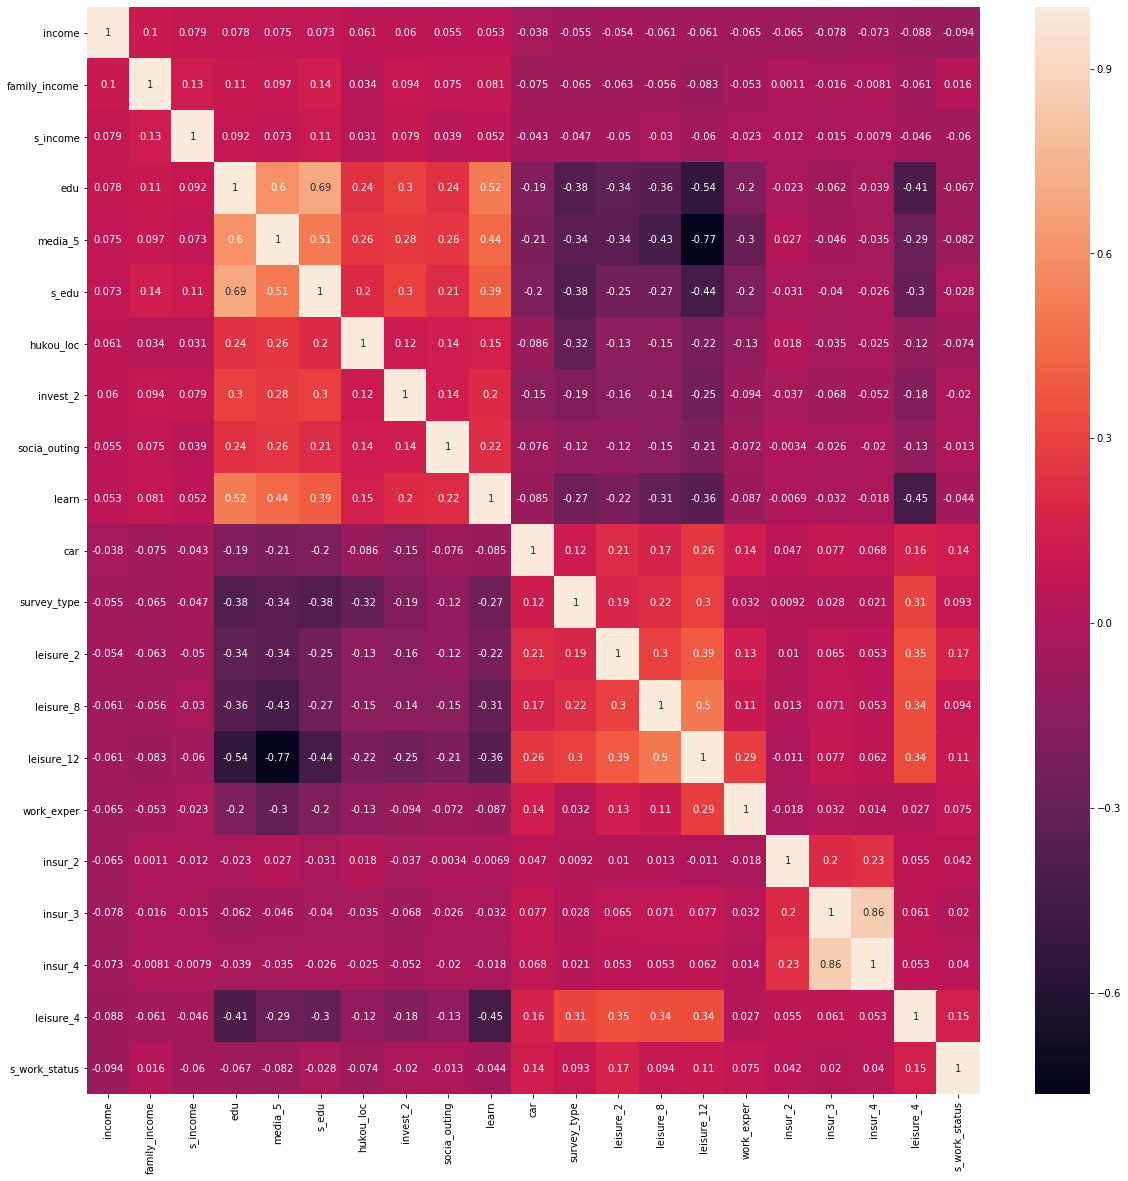

In [91]:
plt.subplots(figsize=(20, 20))
sns.heatmap(hit_map_data, annot=True)

In [76]:
import random

In [102]:
y = np.array(train_y, dtype=int)
X = np.array(train_data, dtype="float32")
test_X = np.array(test_data, dtype="float32")
tmpxy = [(X[i],y[i]) for i in range(len(y))]
random.shuffle(tmpxy)
test_num = int(len(tmpxy)*0.1)
train_xy = tmpxy[test_num:]
X = np.array([xy[0] for xy in train_xy])
y = np.array([xy[1] for xy in train_xy])
vaild_xy = tmpxy[:test_num]
vaild_X = np.array([xy[0] for xy in vaild_xy])
vaild_y = np.array([xy[1] for xy in vaild_xy])

In [85]:
import tensorflow as tf

In [95]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=128, activation='relu', input_dim=134))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    model.add(tf.keras.layers.Dense(units=16, activation='relu'))
    model.add(tf.keras.layers.Dense(units=5, activation='softmax'))
    return model

In [96]:
model = get_model()